In [1]:
from PIL import Image
import numpy as np
import torch
from diffusers import StableDiffusionInpaintPipeline,DDIMScheduler
from torchvision.io import read_image, ImageReadMode
import torch.nn.functional as F
from torchvision.transforms.functional import gaussian_blur
from pytorch_lightning import seed_everything
import os
from torchvision.utils import save_image
import cv2
from matplotlib import pyplot as plt

/usr/local/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
#scheduler = DPMSolverMultistepScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear",solver_order=3)
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "/hy-tmp/SD2-1-base",
    scheduler=scheduler,
    custom_pipeline="/hy-tmp/MyREMOVAL/pipeline_inp.py",
    torch_dtype=torch.float16,  
)
pipe.to(device)
pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...: 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]
/root/.cache/huggingface/modules/diffusers_modules/local/pipeline_inp.py:291: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.27.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very

In [3]:
#freeU
from free_lunch_utils import register_free_upblock2d, register_free_crossattn_upblock2d
register_free_upblock2d(pipe, b1=1.4, b2=1.6, s1=0.9, s2=0.2)
register_free_crossattn_upblock2d(pipe, b1=1.4, b2=1.6, s1=0.9, s2=0.2)

In [52]:

def load_image(image_path, device):
    image = read_image(image_path)
    image = image[:3].unsqueeze_(0).float() / 127.5 - 1.  # [-1, 1]
    image = F.interpolate(image, (512, 512), mode="bicubic")
    image = image.to(torch.float16).to(device)
    return image

def load_mask(mask_path, device):
    mask = read_image(mask_path,mode=ImageReadMode.GRAY)
    mask = mask.unsqueeze_(0).float() / 255.  # 0 or 1
    mask = F.interpolate(mask, (512, 512), mode="bicubic")
    mask = gaussian_blur(mask, kernel_size=(13,13))
    mask[mask < 0.01] = 0
    mask[mask >= 0.01] = 1
    mask = mask.to(torch.float16).to(device)
    return mask

#seed = 777 #222
seed = 321 #777no
seed_everything(seed)
generator=torch.Generator("cuda").manual_seed(seed)
sample = "ff" 
out_dir = f"./workdir_inp/{sample}/"
os.makedirs(out_dir, exist_ok=True)
sample_count = len(os.listdir(out_dir))
out_dir = os.path.join(out_dir, f"sample_{sample_count}")
#out_dir = os.path.join(out_dir, "40")
os.makedirs(out_dir, exist_ok=True)
# source image
SOURCE_IMAGE_PATH = f"/hy-tmp/MyREMOVAL/examples/img/{sample}.png"
MASK_PATH = f"/hy-tmp/MyREMOVAL/examples/mask/{sample}_mask.png"
prompt = ""

#SOURCE_IMAGE_PATH = "/hy-tmp/DATA/sample/b5e79249f8151459_m01yrx_775722c0.jpg"
#MASK_PATH = "/hy-tmp/DATA/sample/b5e79249f8151459_m01yrx_775722c0_mask.png"
#/hy-tmp/outputs_mine/00a55e292e46550a_m03m3pdh_6c778d36.png
#/hy-tmp/DATA/sample/cbdcaf205d02edf2_m026qbn5_0092f793.jpg
#/hy-tmp/outputs_mine/004130acea29204f_m0bt9lr_64749b83.png
#/hy-tmp/sd_new/c7d1a7a1605b9dd2_m0174n1_039ff462.png #shoutao
#/hy-tmp/sd_new/0a451ad29b8506c9_m015p6_4bc83bd1.png
#/hy-tmp/DATA/sample/4555b8698ca652f5_m06_fw_350e59e3.jpg huaban
##source_image = load_image("/hy-tmp/DATA/sample/c2b8e5978146d18e_m03bt1vf_b089318d.jpg", device) #huabing
#source_image = load_image("/hy-tmp/DATA/sample/155b09c9570670f3_m09728_575e1690.jpg", device) #bin
#source_image = load_image("/hy-tmp/DATA/sample/bcfa0c7ce176f096_m01m2v_b0cad050.jpg", device) # abl for layer
#source_image = load_image("/hy-tmp/DATA/sample/cfc13f689bc316fe_m03bt1vf_c8041a04.jpg", device) # all_layer
#source_image = load_image("/hy-tmp/DATA/sample/3205bdb5bf767046_m04dr76w_8cfcb545.jpg", device) #lipstick
source_image = load_image(SOURCE_IMAGE_PATH, device)
mask_an = load_mask(MASK_PATH, device)


Seed set to 321


In [53]:
#image_path = "/hy-tmp/DATA/sample/c2b8e5978146d18e_m03bt1vf_b089318d.jpg"
#/hy-tmp/DATA/sample/bf8971a7489a79a1_m06msq_8a1b5ea1.jpg g1
#/hy-tmp/DATA/sample/bf30517d6f4d3977_m0bt9lr_5a250145.jpg g2!!
#/hy-tmp/DATA/sample/c1bb35c59cdaee81_m0cmf2_11eb2645.jpg g3
#/hy-tmp/DATA/sample/c6bd42364c81b621_m0342h_4b65abe4.jpg g4
#/hy-tmp/DATA/sample/c6d074f198a524d7_m0hdln_a7793cbf.jpg g5
#/hy-tmp/DATA/sample/c8a86d6c879aac3d_m0h2r6_e1e02970.jpg g6
#/hy-tmp/DATA/sample/c8b3ee6984721a12_m01mqdt_eee32259.jpg g7!!!
#/hy-tmp/DATA/sample/c08c270833414c6c_m01s55n_bdced13b.jpg
#/hy-tmp/DATA/sample/c16ccebaa8fb1f2e_m02fq_6_46b3ab50.jpg hat
#/hy-tmp/DATA/sample/c22a3f66673a77cd_m02p0tk3_16582e00.jpg
#/hy-tmp/DATA/sample/c86f9ee870e977ac_m0gd36_e519857a.jpg
#source_image = load_image("/hy-tmp/DATA/sample/b5e79249f8151459_m01yrx_775722c0.jpg", device) #cat
#ource_image = load_image("/hy-tmp/DATA/sample/b7ac9c6bcfe0ff4e_m09728_6e1b66f8.jpg", device) #ff
#source_image = load_image("/hy-tmp/DATA/sample/3205bdb5bf767046_m04dr76w_8cfcb545.jpg", device) #lipstick
#source_image = load_image("/hy-tmp/DATA/sample/a6d7562694eba880_m034c16_f939b3c4.jpg", device) #zhentou1 123
#source_image = load_image("/hy-tmp/DATA/sample/c2b8e5978146d18e_m03bt1vf_b089318d.jpg", device) #huabing
#source_image = load_image("/hy-tmp/DATA/sample/155b09c9570670f3_m09728_575e1690.jpg", device) #bin
#source_image = load_image("/hy-tmp/DATA/sample/3635c19d51895f11_m06msq_ef114c7e.jpg", device) #fff
#source_image = load_image("/hy-tmp/DATA/sample/bcfa0c7ce176f096_m01m2v_b0cad050.jpg", device) # abl for w

In [54]:
from masactrl.masactrl import MutualSelfAttentionControlMask_An_opt,MutualSelfAttentionControlMask_An
from masactrl.masactrl_utils import regiter_attention_editor_diffusers
strength = 0.9
num_inference_steps = 50
START_STEP = 0
END_STEP = int(strength*num_inference_steps)
LAYER = 7 #0~5down,6mid,7~15up
END_LAYER = 16

removelist=[6]
#removelist=[3,4,5,6,7]
layer_idx=list(range(LAYER, END_LAYER))
""" 
for i in removelist:
    layer_idx.remove(i) """
# hijack the attention module
editor = MutualSelfAttentionControlMask_An_opt(START_STEP, END_STEP, LAYER, END_LAYER,layer_idx= layer_idx, mask=mask_an)
#editor = MutualSelfAttentionControlMask_An(START_STEP, END_STEP, LAYER, END_LAYER,layer_idx= layer_idx, mask=mask_an)

regiter_attention_editor_diffusers(pipe, editor)

In [55]:
image_s = Image.open(SOURCE_IMAGE_PATH).convert('RGB')
mask = Image.open(MASK_PATH)
#image, pred_x0_list_denoise, latents_list_denoise = pipe(
image = pipe(
            prompt=prompt, 
            image=image_s, 
            mask_image=mask,
            num_inference_steps = num_inference_steps,
            strength=strength,
            generator=generator, 
            rm_guidance_scale=9,
            guidance_scale = 1,
            return_intermediates = False)

In [56]:
def make_redder(img, mask, increase_factor=0.25):
    # 创建一个拷贝以避免修改原始图像
    img_redder = img.clone()
    mask_expanded = mask.expand_as(img)
    # 增加红色分量（第一个通道）在 mask 为 1 的区域
    img_redder[0][mask_expanded[0] == 1] = torch.clamp(img_redder[0][mask_expanded[0] == 1] + increase_factor, 0, 1)
    
    return img_redder
img = (source_image* 0.5 + 0.5).squeeze(0)
mask_red = mask_an.squeeze(0)
img_redder = make_redder(img, mask_red)
#save_image(img_redder, os.path.join(out_dir, "redder.png"))

In [57]:
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image, ImageFilter
pil_mask = to_pil_image(mask_an.squeeze(0))
pil_mask_blurred = pil_mask.filter(ImageFilter.GaussianBlur(radius=15))
mask_blurred = to_tensor(pil_mask_blurred).unsqueeze_(0).to(mask_an.device)
msak_f = 1-(1-mask_an)*(1-mask_blurred)

Syntheiszed images are saved in ./workdir_inp/ff/sample_0


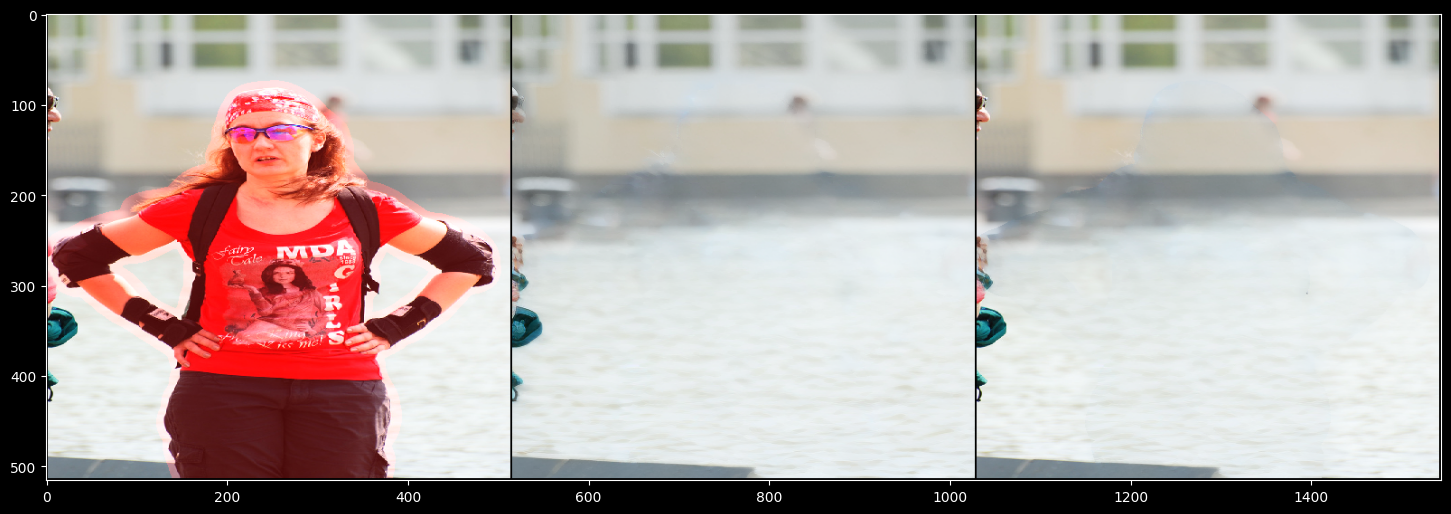

In [58]:
#out_tile = mask_an * image[-1:] + (1 - mask_an) * (source_image* 0.5 + 0.5)
#out_tile_1 = mask_blurred * image[-1:] + (1 - mask_blurred) * out_tile
out_tile_1 = msak_f * image[-1:] + (1 - msak_f) * (source_image* 0.5 + 0.5)
#out_image = torch.concat([source_image* 0.5 + 0.5,
out_image = torch.concat([img_redder.unsqueeze(0),
                         image[-1:],
                         out_tile_1],
                         #image[:1]],
                         dim=0)
save_image(out_image, os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[0], os.path.join(out_dir, f"source_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[1], os.path.join(out_dir, f"anonymous_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[2], os.path.join(out_dir, f"anonymous_tile_step{END_STEP}_layer{LAYER}.png"))
#save_image(out_image[2], os.path.join(out_dir, f"compare_step{END_STEP}_layer{LAYER}.png"))
print("Syntheiszed images are saved in", out_dir)
img_ori = cv2.imread(os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(18, 24))
plt.imshow(img_ori)

In [59]:
""" fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    #vl = [img.cpu().permute(0, 2, 3, 1).numpy()[0] for img in latents_list_denoise[41:51]]
    vl = [img.cpu().permute(0, 2, 3, 1).numpy()[0] for img in pred_x0_list_denoise[:10]]
    ax.imshow((vl[i]*255).astype(np.uint8))
    ax.axis('off')
plt.show() """

" fig, axs = plt.subplots(2, 5, figsize=(15, 6))\nfor i, ax in enumerate(axs.flatten()):\n    #vl = [img.cpu().permute(0, 2, 3, 1).numpy()[0] for img in latents_list_denoise[41:51]]\n    vl = [img.cpu().permute(0, 2, 3, 1).numpy()[0] for img in pred_x0_list_denoise[:10]]\n    ax.imshow((vl[i]*255).astype(np.uint8))\n    ax.axis('off')\nplt.show() "